# Whistle Vectorization and Visualization

This notebook demonstrates how to:
1. Load whistle detections from a CSV file
2. Vectorize the detected whistles
3. Plot the whistle contours

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from AutomaticExtraction.dtw_variance import vectorize_wh_zones, merge_consecutive_windows, distance_wh_zones, Extract_Whistles
from AutomaticExtraction.spectrogram import wav_to_spec

In [2]:
# Load the detections CSV file
audio_path = "examples/example_audio.wav"  # Replace with your audio file
csv_path = "examples/example_audio/example_audio.wav_predictions.csv"  # Replace with your CSV file
csv_df = pd.read_csv(csv_path)

In [3]:
# Vectorize the whistle zones
detections_df = merge_consecutive_windows(csv_df)
wht, whf = vectorize_wh_zones(audio_path, detections_df, window_size=8, 
                              delta=3, min_freq=3000, max_freq=30000)

100%|██████████| 9/9 [00:01<00:00,  5.04it/s]


In [4]:
# Get the spectrogram for visualization
specgram, freqs, times = wav_to_spec(
    audio_path,
    stride_ms=10.0,
    window_ms=20.0,
    max_freq=20000,
    min_freq=1000
)

#specgram = spectral_subtraction(specgram)
#specgram = filter_edges_spectrogram(specgram)

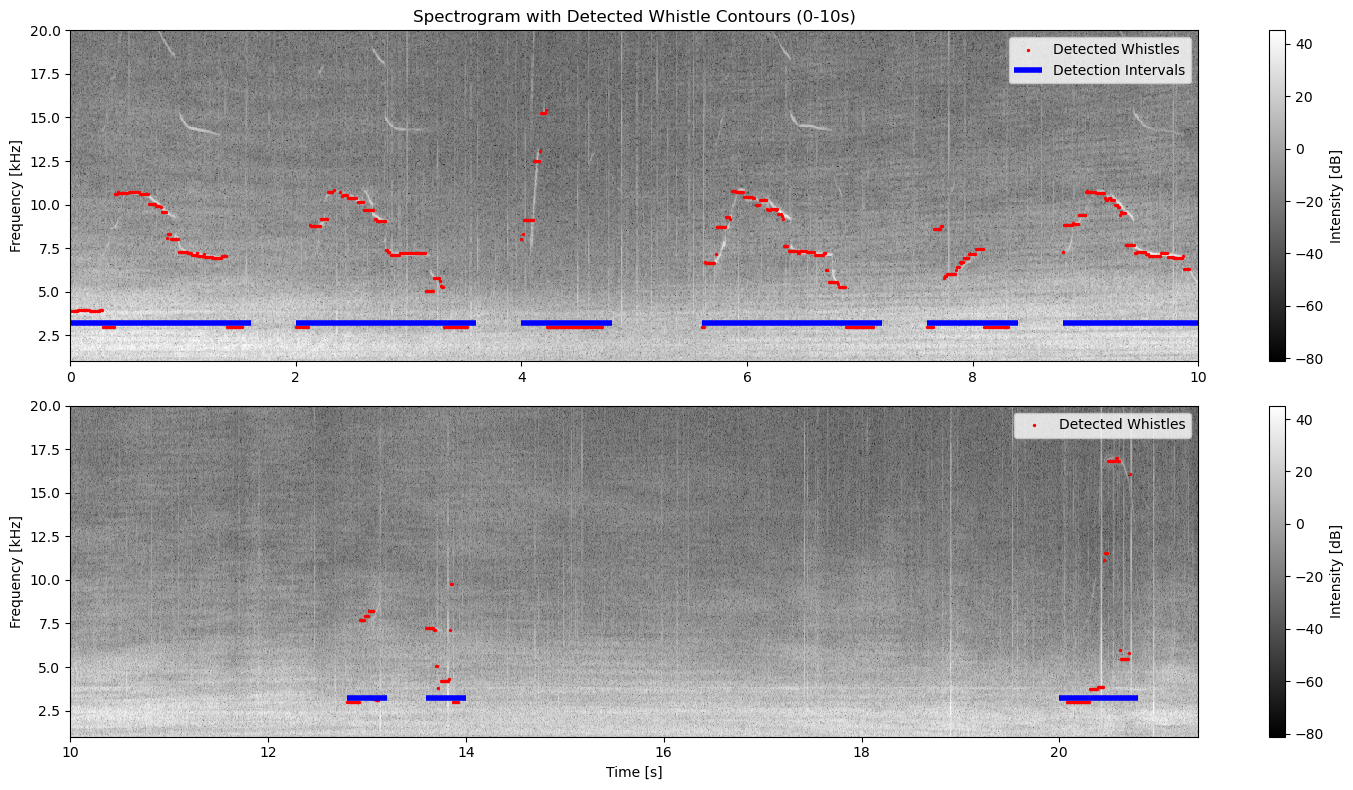

In [5]:
# Create the visualization with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

# First subplot (0-10 seconds)
# Plot spectrogram
im1 = ax1.pcolormesh(times, freqs/1000, 10 * np.log10(specgram + 1e-14), cmap='gray')
plt.colorbar(im1, ax=ax1, label='Intensity [dB]')

# Plot vectorized whistles (first 10 seconds)
mask1 = wht <= 10
ax1.scatter(wht[mask1], whf[mask1]/1000, c='r', s=2, label='Detected Whistles')

# Add detection intervals
for _, row in detections_df.iterrows():
    start_time = row['initial_point']
    end_time = row['finish_point']
    if start_time <= 10:  # Only plot intervals in first 10 seconds
        ax1.hlines(y=3.2, xmin=start_time, xmax=min(end_time, 10), colors='blue', linewidth=4,
                  label='Detection Intervals' if _ == 0 else "")

# Customize first subplot
ax1.set_ylabel('Frequency [kHz]')
ax1.set_title('Spectrogram with Detected Whistle Contours (0-10s)')
ax1.legend()
ax1.set_ylim(1, 20)
ax1.set_xlim(0, 10)

# Second subplot (after 10 seconds)
# Plot spectrogram
im2 = ax2.pcolormesh(times, freqs/1000, 10 * np.log10(specgram + 1e-14), cmap='gray')
plt.colorbar(im2, ax=ax2, label='Intensity [dB]')

# Plot vectorized whistles (after 10 seconds)
mask2 = wht > 10
ax2.scatter(wht[mask2], whf[mask2]/1000, c='r', s=2, label='Detected Whistles')

# Add detection intervals
for _, row in detections_df.iterrows():
    start_time = row['initial_point']
    end_time = row['finish_point']
    if end_time > 10:  # Only plot intervals after 10 seconds
        ax2.hlines(y=3.2, xmin=max(start_time, 10), xmax=end_time, colors='blue', linewidth=4,
                  label='Detection Intervals' if _ == 0 else "")

# Customize second subplot
ax2.set_ylabel('Frequency [kHz]')
ax2.set_xlabel('Time [s]')
ax2.legend()
ax2.set_ylim(1, 20)
ax2.set_xlim(10, times[-1])

plt.tight_layout()
plt.show()

The red lines show the detected whistle contours overlaid on the spectrogram. 
Each contour represents the frequency trajectory of a detected whistle over time.

In [6]:

filepath_annotation = "/users/zfne/mustun/Documents/GitHub/Dolphins/examples/templates/SW_Neo_2.mat"
annots = loadmat(filepath_annotation)
## Get frequency and time
annots_freqs = annots['whf'][0]
annots_times = annots['wht'][0]
annots_name = filepath_annotation.split('/')[-1].split('.')[0]

Distance, Norm_Distance = distance_wh_zones(wht, whf, annots_freqs, annots_times, alphas = (0.5,1.25), n_jobs=36)
Wh, _, whistles_index = Extract_Whistles(Distance, Norm_Distance, whf, wht, annots_times, annots_freqs, 
                                        annotation_name=annots_name, threshold=3500, n_jobs=36, normalized=True)

100%|██████████| 839/839 [00:01<00:00, 702.74it/s]


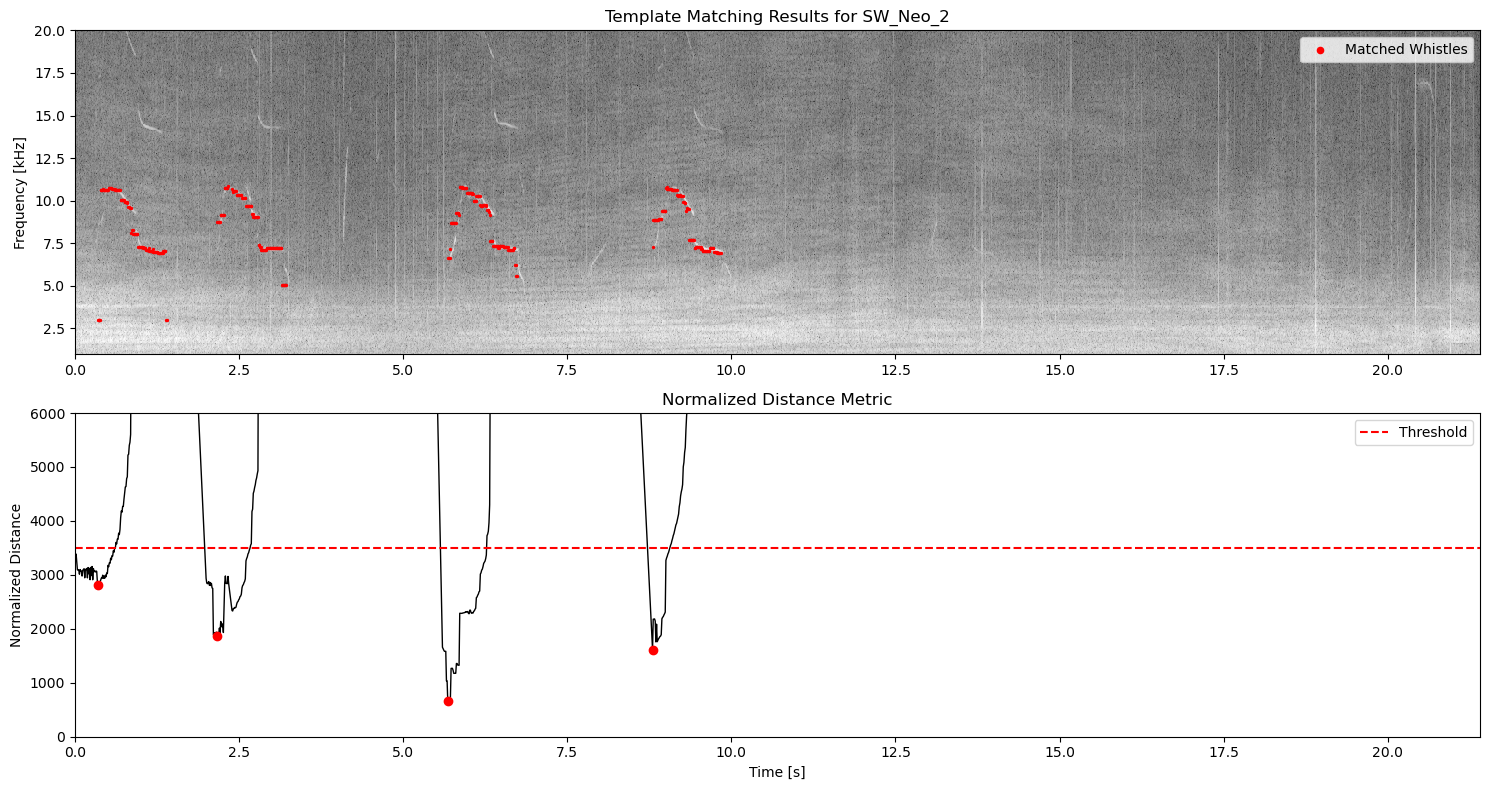

In [7]:
# Plot the extracted whistles from the template matching
plt.figure(figsize=(15, 8))

# Plot the spectrogram
ax1 = plt.subplot(2, 1, 1)
im1 = ax1.pcolormesh(times, freqs/1000, 10 * np.log10(specgram + 1e-14), cmap='gray')
# Removed colorbar as requested

# Plot the distance metric
ax2 = plt.subplot(2, 1, 2)
ax2.plot(wht, Norm_Distance, 'k-', linewidth=1)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Normalized Distance')
ax2.axhline(y=3500, color='r', linestyle='--', label='Threshold')

# Mark the detected whistles on both plots
for i, whistle in enumerate(Wh):
    # Mark on distance plot
    whistle_time = whistle['onset']  # Use the onset time from the whistle
    whistle_index = np.argmin(np.abs(wht - whistle_time))  # Find closest index
    ax2.plot(wht[whistle_index], Norm_Distance[whistle_index], 'ro')
    
    # Mark on spectrogram
    ax1.scatter(whistle['wht'], whistle['whf']/1000, c='r', s=2)
    # Add a label for the first whistle only to avoid duplicate legend entries
    if i == 0:
        ax1.scatter([], [], c='r', s=20, label='Matched Whistles')

# Customize spectrogram plot
ax1.set_ylabel('Frequency [kHz]')
ax1.set_title(f'Template Matching Results for {annots_name}')
ax1.set_ylim(1, 20)
ax1.set_xlim(0, times[-1])
ax1.legend()

# Customize distance plot
ax2.set_title('Normalized Distance Metric')
ax2.legend()
ax2.set_ylim(0, 6000)
ax2.set_xlim(0, times[-1])

plt.tight_layout()
plt.show()
